# Question 3

## Loading Dataset and preparting it

In [33]:
from sklearn.datasets import load_iris
import pandas as pd
iris = load_iris(as_frame=True)

df = pd.DataFrame(iris.data, columns=iris.feature_names)


df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [34]:
df['species'] = iris.target_names[iris.target]

# Drop rows where species is 'virginica'
df_filtered = df[df['species'] != 'virginica']
df_filtered.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,100.000000,100.000000,100.000000,100.000000
mean,5.471000,3.099000,2.861000,0.786000
std,0.641698,0.478739,1.449549,0.565153
min,4.300000,2.000000,1.000000,0.100000
25%,5.000000,2.800000,1.500000,0.200000
50%,5.400000,3.050000,2.450000,0.800000
75%,5.900000,3.400000,4.325000,1.300000
max,7.000000,4.400000,5.100000,1.800000


In [35]:
# Drop the 'species' column temporarily (only scale features)
features = df_filtered.drop(columns=['species'])

# Min-Max scaling manually (0 to 1)
df_normalized = (features - features.min()) / (features.max() - features.min())

# Add 'species' column back
df_normalized['species'] = df_filtered['species']

# Verify
df_normalized.drop(columns=['sepal length (cm)', 'sepal width (cm)'], inplace=True)
df_normalized.describe()

,petal length (cm),petal width (cm)
count,100.000000,100.000000
mean,0.453902,0.403529
std,0.353548,0.332443
min,0.000000,0.000000
25%,0.121951,0.058824
50%,0.353659,0.411765
75%,0.810976,0.705882
max,1.000000,1.000000


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Separate features (X) and target (y)
X = df_normalized.drop(columns=['species'])  # Features
y = df_normalized['species']                 # Target

# Encode target variable (convert strings to 0 and 1)
le = LabelEncoder()
y = le.fit_transform(y)  # y is now encoded as integers

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3, 
    random_state=42,
    stratify=y  # Preserve class distribution using encoded labels
)

print(f"Training features: {X_train.shape}")
print(f"Test features: {X_test.shape}")
print(f"Training target: {y_train.shape}")
print(f"Test target: {y_test.shape}")

Training features: (70, 2)
Test features: (30, 2)
Training target: (70,)
Test target: (30,)


## Adaline Implementation 

In [37]:
import numpy as np

def adaline(input_neurons, output_neurons, learning_rate, epochs, X_train, y_train):
    # Initialize parameters
    #np.random.seed(10)
    weights = np.random.randn(input_neurons, output_neurons) * 0.1
    bias = np.zeros((1, output_neurons))
    # Storage for training history
    history = {
        'weights': [],
        'biases': [],
        'errors': [],
        'accuracies': []
    }
    # Convert y_train to column vector
    y_train = y_train.reshape(-1, 1)
    for epoch in range(epochs):
        # Forward pass
        net_input = np.dot(X_train, weights) + bias
        # Calculate mean squared error
        error = np.mean((net_input - y_train) ** 2)
        # Calculate gradients
        error_gradient = net_input - y_train
        grad_weights = (2/X_train.shape[0]) * np.dot(X_train.T, error_gradient)
        grad_bias = (2/X_train.shape[0]) * np.sum(error_gradient, axis=0)
        # Update parameters
        weights -= learning_rate * grad_weights
        bias -= learning_rate * grad_bias
        # Calculate accuracy
        predictions = (net_input >= 0.5).astype(int)
        accuracy = np.mean(predictions == y_train)
        # Store metrics
        history['weights'].append(weights.copy())
        history['biases'].append(bias.copy())
        history['errors'].append(error)
        history['accuracies'].append(accuracy)
        
    return history

## Training the models with Learning rate -> 0.02 vs 0.005 vs 0.001

In [38]:
Epochs = 50
input_neurons = X_train.shape[1]  # Number of features
output_neurons = 1                # Binary classification

Model_002 = adaline(input_neurons, output_neurons, 0.02, Epochs, X_train, y_train)
Model_0005 = adaline(input_neurons, output_neurons, 0.005, Epochs, X_train, y_train)
Model_0001 = adaline(input_neurons, output_neurons, 0.001, Epochs, X_train, y_train)

## Graphs and Statistics

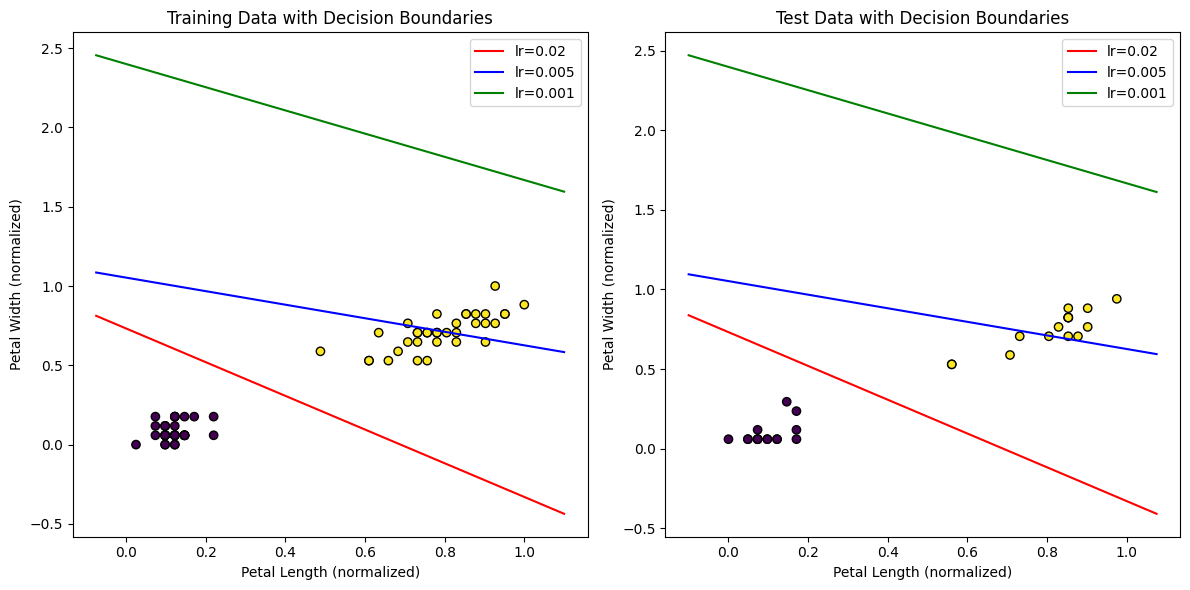

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the final weights and biases from the model histories and flatten them.
# bias is stored as a 2D array, so we extract the scalar value.
w_002 = Model_002['weights'][-1].flatten()
b_002 = Model_002['biases'][-1].flatten()[0]
w_0005 = Model_0005['weights'][-1].flatten()
b_0005 = Model_0005['biases'][-1].flatten()[0]
w_0001 = Model_0001['weights'][-1].flatten()
b_0001 = Model_0001['biases'][-1].flatten()[0]

def decision_boundary(x, w, b):
    """
    Calculate y values along the decision boundary:
      w[0]*x + w[1]*y + b = 0.5  -> y = (0.5 - b - w[0]*x) / w[1]
    """
    return (0.5 - b - w[0] * x) / w[1]

# Set up the figure with two subplots: one for training data and one for test data.
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.scatter(
    X_train['petal length (cm)'], 
    X_train['petal width (cm)'], 
    c=y_train, 
    cmap='viridis', 
    edgecolor='k'
)
plt.xlabel('Petal Length (normalized)')
plt.ylabel('Petal Width (normalized)')
plt.title('Training Data with Decision Boundaries')

# Create an array of x values that spans the range of petal length in the training set.
x_vals = np.linspace(
    X_train['petal length (cm)'].min() - 0.1, 
    X_train['petal length (cm)'].max() + 0.1, 
    200
)

# Plot decision boundaries for each model.
plt.plot(x_vals, decision_boundary(x_vals, w_002, b_002), color='red', label='lr=0.02')
plt.plot(x_vals, decision_boundary(x_vals, w_0005, b_0005), color='blue', label='lr=0.005')
plt.plot(x_vals, decision_boundary(x_vals, w_0001, b_0001), color='green', label='lr=0.001')
plt.legend()


plt.subplot(1, 2, 2)
plt.scatter(
    X_test['petal length (cm)'], 
    X_test['petal width (cm)'], 
    c=y_test, 
    cmap='viridis', 
    edgecolor='k'
)
plt.xlabel('Petal Length (normalized)')
plt.ylabel('Petal Width (normalized)')
plt.title('Test Data with Decision Boundaries')


x_vals_test = np.linspace(
    X_test['petal length (cm)'].min() - 0.1, 
    X_test['petal length (cm)'].max() + 0.1, 
    200
)

plt.plot(x_vals_test, decision_boundary(x_vals_test, w_002, b_002), color='red', label='lr=0.02')
plt.plot(x_vals_test, decision_boundary(x_vals_test, w_0005, b_0005), color='blue', label='lr=0.005')
plt.plot(x_vals_test, decision_boundary(x_vals_test, w_0001, b_0001), color='green', label='lr=0.001')
plt.legend()

plt.tight_layout()
plt.show()


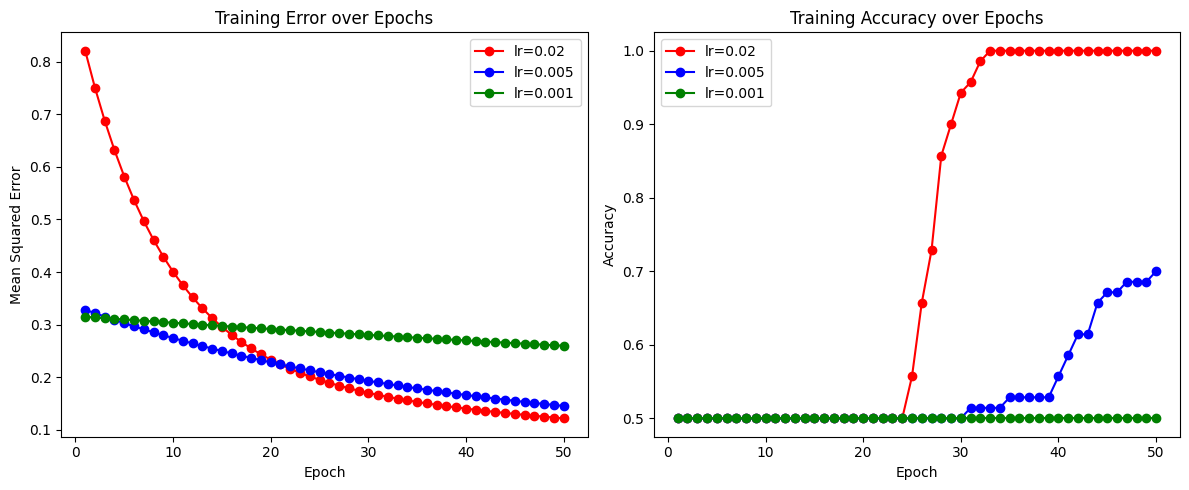

In [40]:
import matplotlib.pyplot as plt

epochs = range(1, Epochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, Model_002['errors'], marker='o', label='lr=0.02', color='red')
plt.plot(epochs, Model_0005['errors'], marker='o', label='lr=0.005', color='blue')
plt.plot(epochs, Model_0001['errors'], marker='o', label='lr=0.001', color='green')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training Error over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, Model_002['accuracies'], marker='o', label='lr=0.02', color='red')
plt.plot(epochs, Model_0005['accuracies'], marker='o', label='lr=0.005', color='blue')
plt.plot(epochs, Model_0001['accuracies'], marker='o', label='lr=0.001', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
